# Clustering the Data


### Load the data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [ ]:
df = pd.read_csv('data/sales_invoiced_lines_basics_cleaned.csv')
df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

In [7]:
print(df.columns)

Index(['Id', 'DimEntityId', 'DimOrderTypeId', 'OrderTypeCode',
       'DimGeographyId', 'Country', 'Date', 'DimGenderId',
       'DimBillToCustomerId', 'CustomerMainType', 'CustomerSubGroup',
       'DimCollectionId', 'DimItemId', 'ItemNo2', 'StyleID', 'Style', 'Color',
       'Size', 'EAN', 'Gender', 'Category', 'SUB Category', 'SUB Category2',
       'Quality', 'Origin Country', 'WHSSalesPriceDKK', 'RRSalesPriceDKK',
       'DimOrderSalespersonId', 'DimOrderCountryManagerId',
       'OrderHeaderNumber', 'OrderLineNumber', 'Inbound Duty', 'Quantity',
       'Amount', 'Discount', 'Cost'],
      dtype='object')


In [8]:
columns_for_clustering = ['Category', 'Quantity', 'WHSSalesPriceDKK', 'RRSalesPriceDKK', 'Amount', 'Gender' , 'SUB Category']
numerical_columns = ['Quantity', 'WHSSalesPriceDKK', 'RRSalesPriceDKK', 'Amount']
categorical_columns = ['Category', 'Gender', 'SUB Category']

### PCA

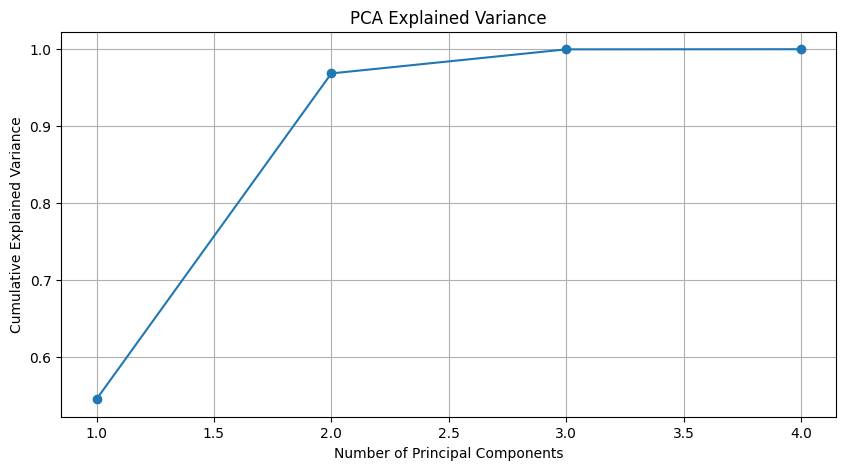

In [9]:

one_hot_encoded_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
one_hot_encoded_columns = [col for col in one_hot_encoded_df.columns if col.startswith("Category") or col.startswith("Gender") or col.startswith("SUB Category")]
columns_for_clustering = numerical_columns + one_hot_encoded_columns
X = one_hot_encoded_df[columns_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_columns])

# Apply PCA
pca = PCA(n_components=None)  # Set to 'None' to keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)
df_preprocessed = preprocessor.fit_transform(df)

Using the elbow method to find the optimal within clustering sum of squares.

## K Means clustering

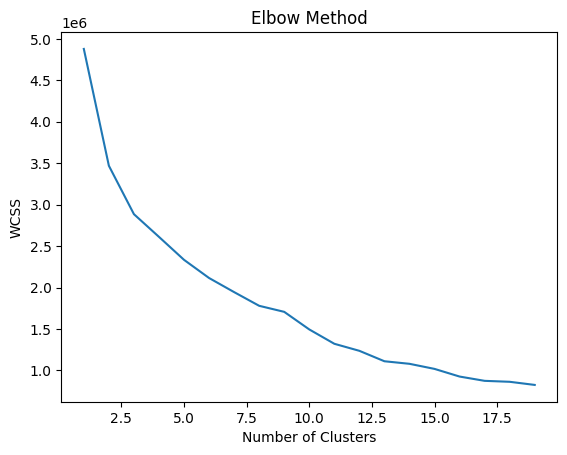

In [11]:

# Finding the optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


In [39]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_preprocessed)
df['Cluster_KMeans'] = kmeans.labels_

### DBScan

In [14]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_preprocessed)

KeyboardInterrupt: 

### Gaussian Based

In [38]:
gmm = GaussianMixture(n_components=10)
gmm.fit(df_preprocessed.toarray())
df['Cluster_GMM'] = gmm.predict(df_preprocessed.toarray())

In [19]:
df.head()

,Id,DimEntityId,DimOrderTypeId,OrderTypeCode,DimGeographyId,Country,Date,DimGenderId,DimBillToCustomerId,CustomerMainType,...,DimOrderCountryManagerId,OrderHeaderNumber,OrderLineNumber,Inbound Duty,Quantity,Amount,Discount,Cost,Cluster,Cluster_GMM
0,459456,43,220,B2BSUP,71,Finland,2022-03-12,2,1715,WHOLESALE,...,2,103099,10002,0.12,2.0,351.18,21.06,151.96,8,2
1,460938,43,220,B2BSUP,57,Germany,2022-03-12,2,1228,WHOLESALE,...,6,103113,50000,0.12,2.0,427.07,0.00,176.62,1,6
2,459441,43,220,B2BSUP,59,Denmark,2022-03-12,1,2519,WHOLESALE,...,2,103083,30000,0.00,2.0,280.00,0.00,126.22,4,1
3,460101,43,220,B2BSUP,167,Netherlands,2022-03-12,2,1532,WHOLESALE,...,3,103142,50003,0.12,1.0,316.21,0.00,160.48,7,4
4,459451,43,220,B2BSUP,59,Denmark,2022-03-12,1,2519,WHOLESALE,...,2,103083,30001,0.00,2.0,280.00,0.00,126.22,4,1


### Cluster analysis

columns_for_clustering = ['Category', 'Quantity', 'WHSSalesPriceDKK', 'RRSalesPriceDKK', 'Amount', 'Gender' , 'SUB Category']
numerical_columns = ['Quantity', 'WHSSalesPriceDKK', 'RRSalesPriceDKK', 'Amount']
categorical_columns = ['Category', 'Gender', 'SUB Category']

In [41]:
def plot_cluster_info(cluster, cluster_type='KMeans'):
    cluster_column = 'Cluster_' + cluster_type
    average_wholesale = df[df[cluster_column] == cluster]['WHSSalesPriceDKK'].mean()
    average_sales_price = df[df[cluster_column] == cluster]['RRSalesPriceDKK'].mean()
    average_amount = df[df[cluster_column] == cluster]['Amount'].mean()
    average_quantity = df[df[cluster_column] == cluster]['Quantity'].mean()
    gender_counts = df[df[cluster_column] == cluster]["Gender"].value_counts()
    category_counts = df[df[cluster_column] == cluster]["Category"].value_counts()
    sub_category_counts = df[df[cluster_column] == cluster]["SUB Category"].value_counts()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    gender_counts.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Gender Distribution in Cluster ' + str(cluster))
    axes[0].set_xlabel('Gender')
    axes[0].set_ylabel('Count')

    category_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Category Distribution in Cluster ' + str(cluster))
    axes[1].set_xlabel('Category')
    axes[1].set_ylabel('Count')

    sub_category_counts.plot(kind='bar', ax=axes[2])
    axes[2].set_title('Sub Category Distribution in Cluster ' + str(cluster))
    axes[2].set_xlabel('Sub Category')
    axes[2].set_ylabel('Count')

    avg_values = pd.Series({
        'Average Wholesale Price': average_wholesale,
        'Average Sales Price': average_sales_price,
        'Average Amount': average_amount,
        'Average Quantity': average_quantity
    })
    avg_values.plot(kind='bar', ax=axes[3])
    axes[3].set_title('Average Values in Cluster ' + str(cluster))
    axes[3].set_xlabel('Metric')
    axes[3].set_ylabel('Value')
    plt.tight_layout()
    plt.show()
    return avg_values

## Plot the cluster infos

### GMM

In [44]:
plot_clusters = True
cluster_type = 'GMM'

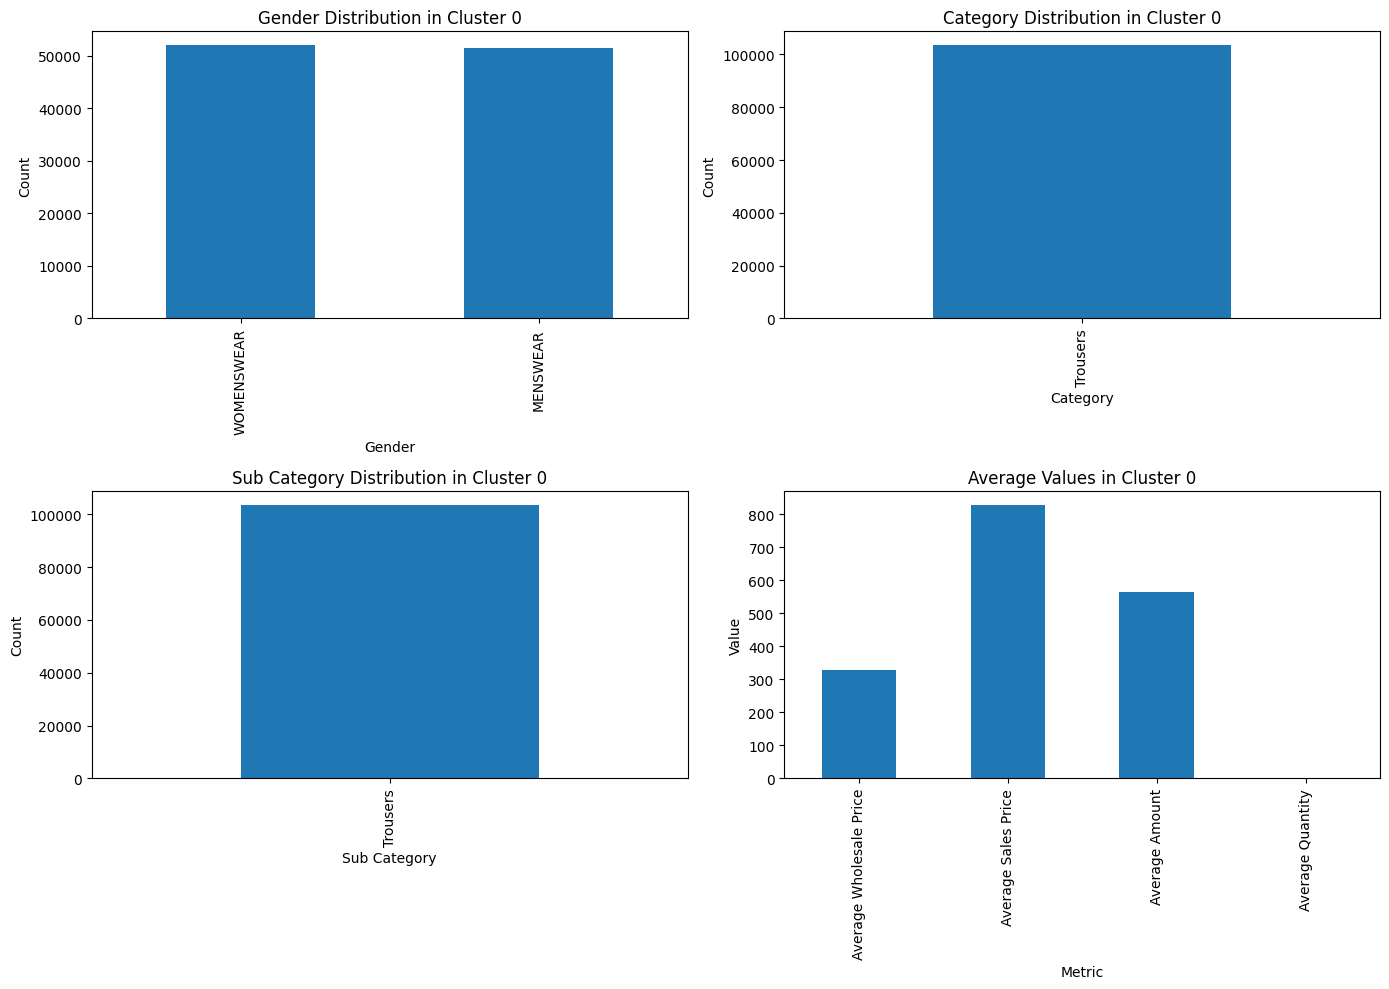

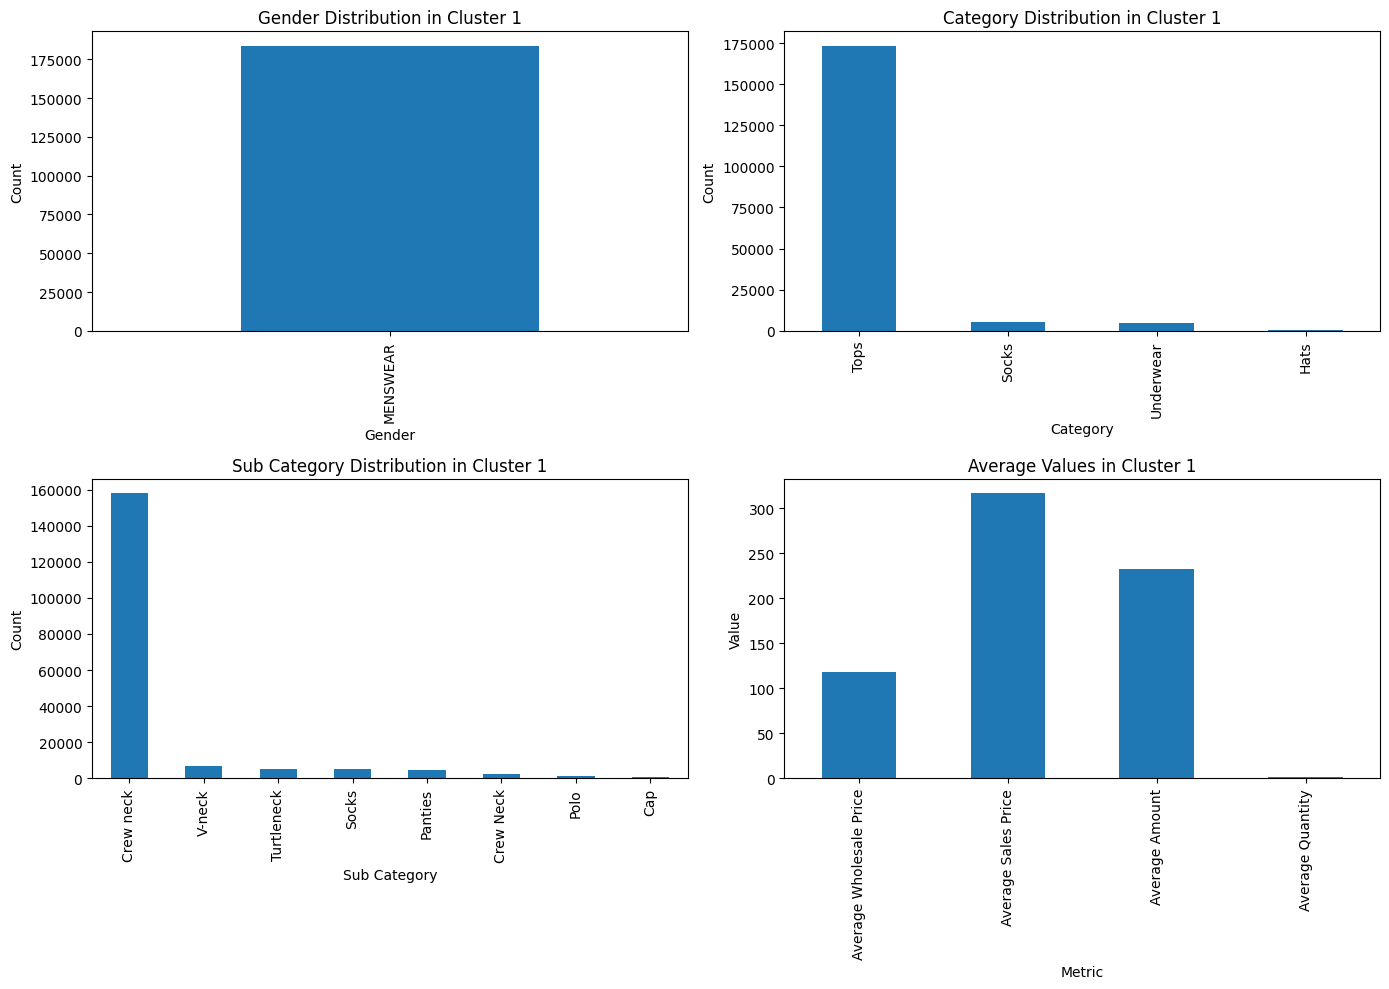

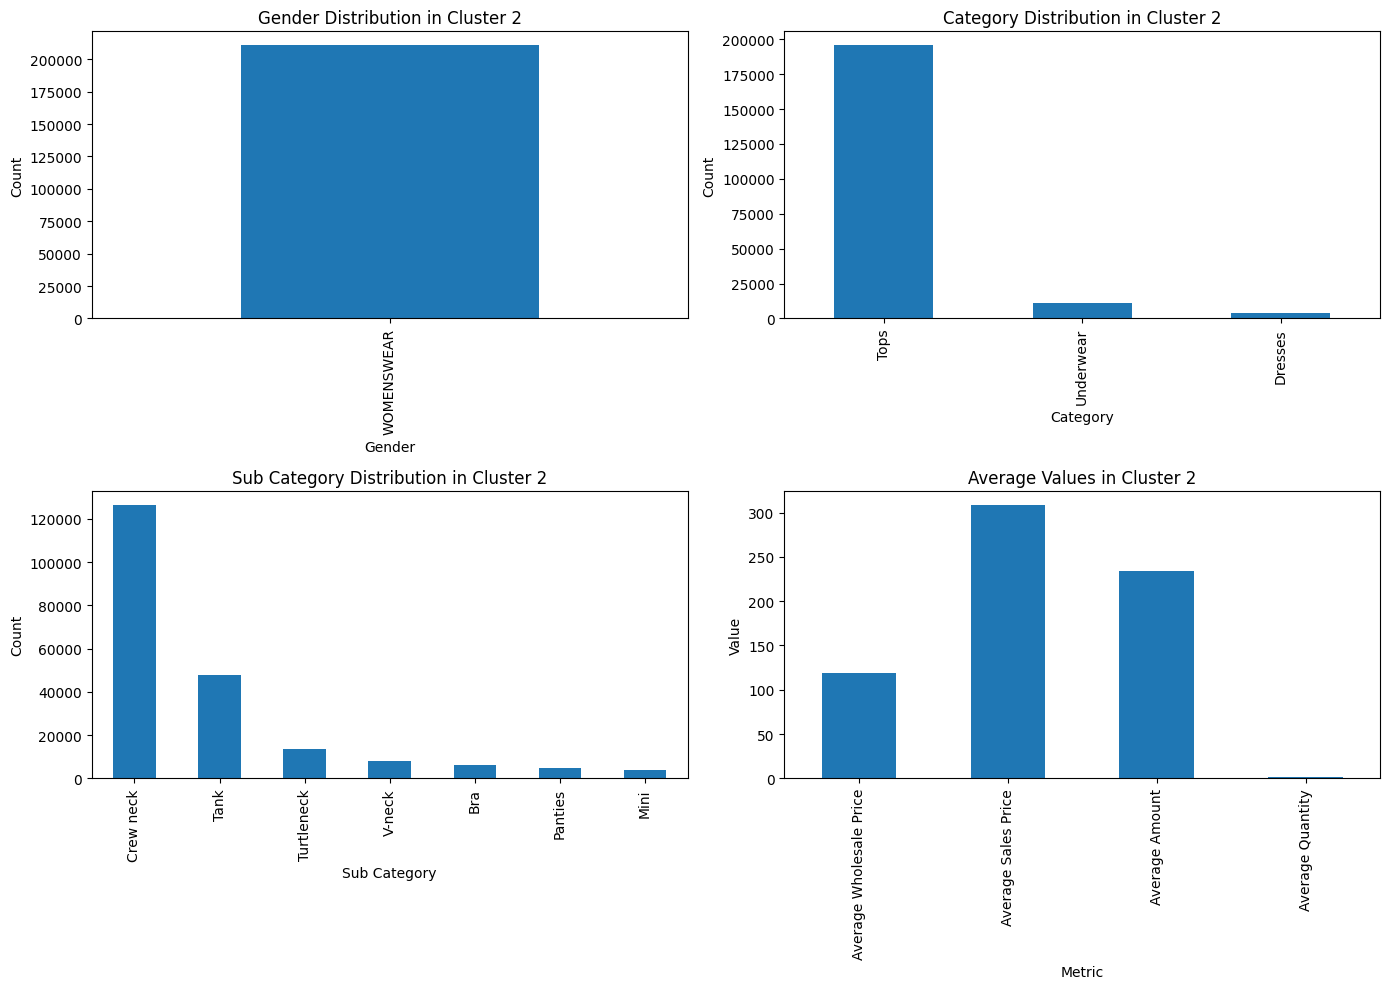

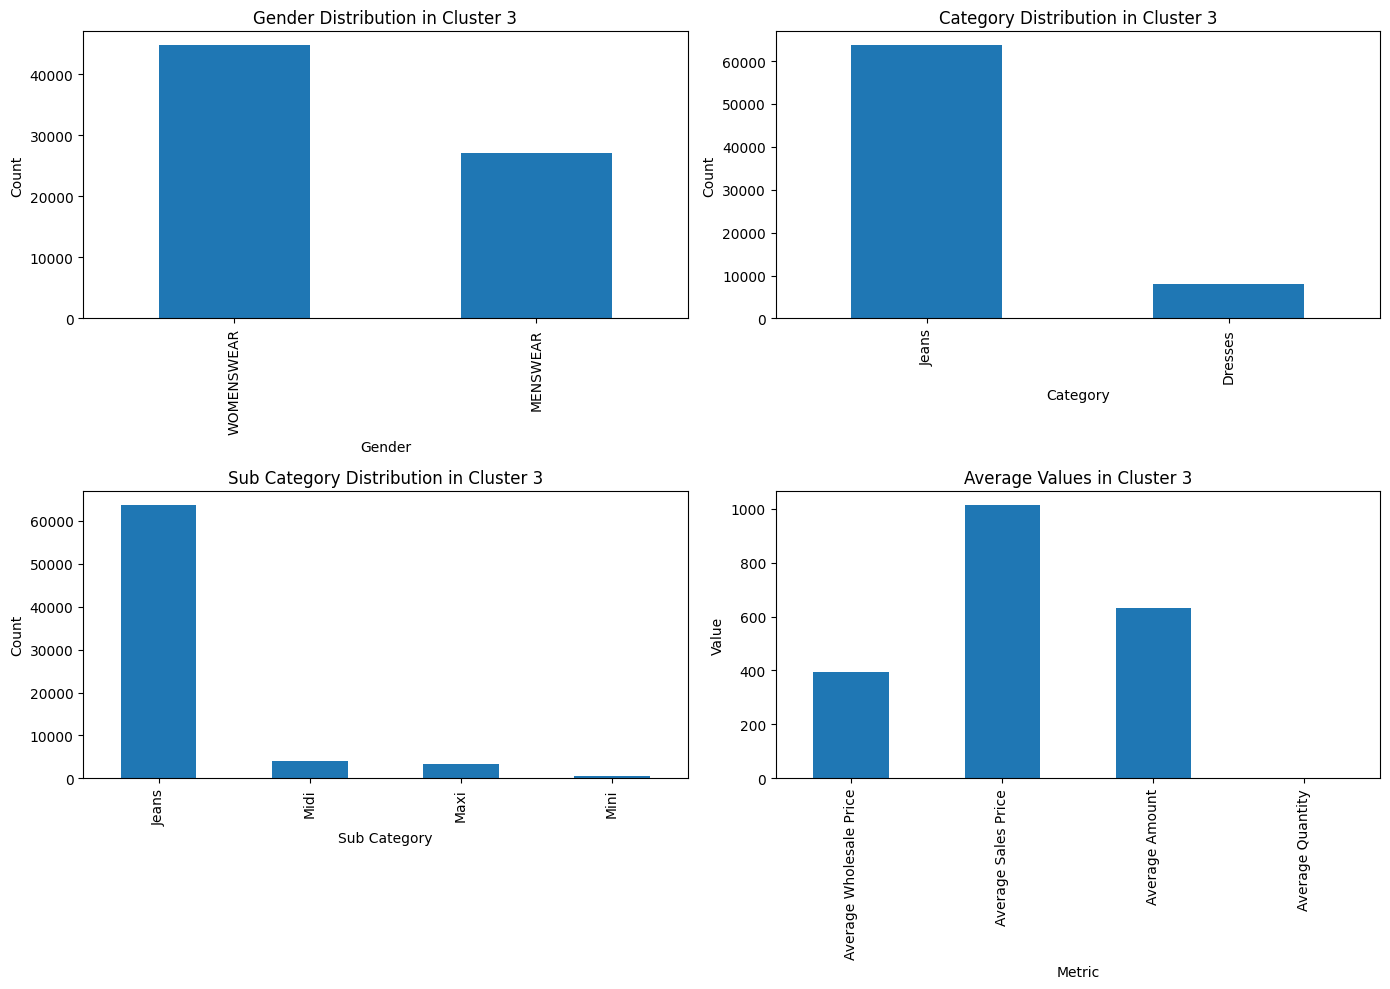

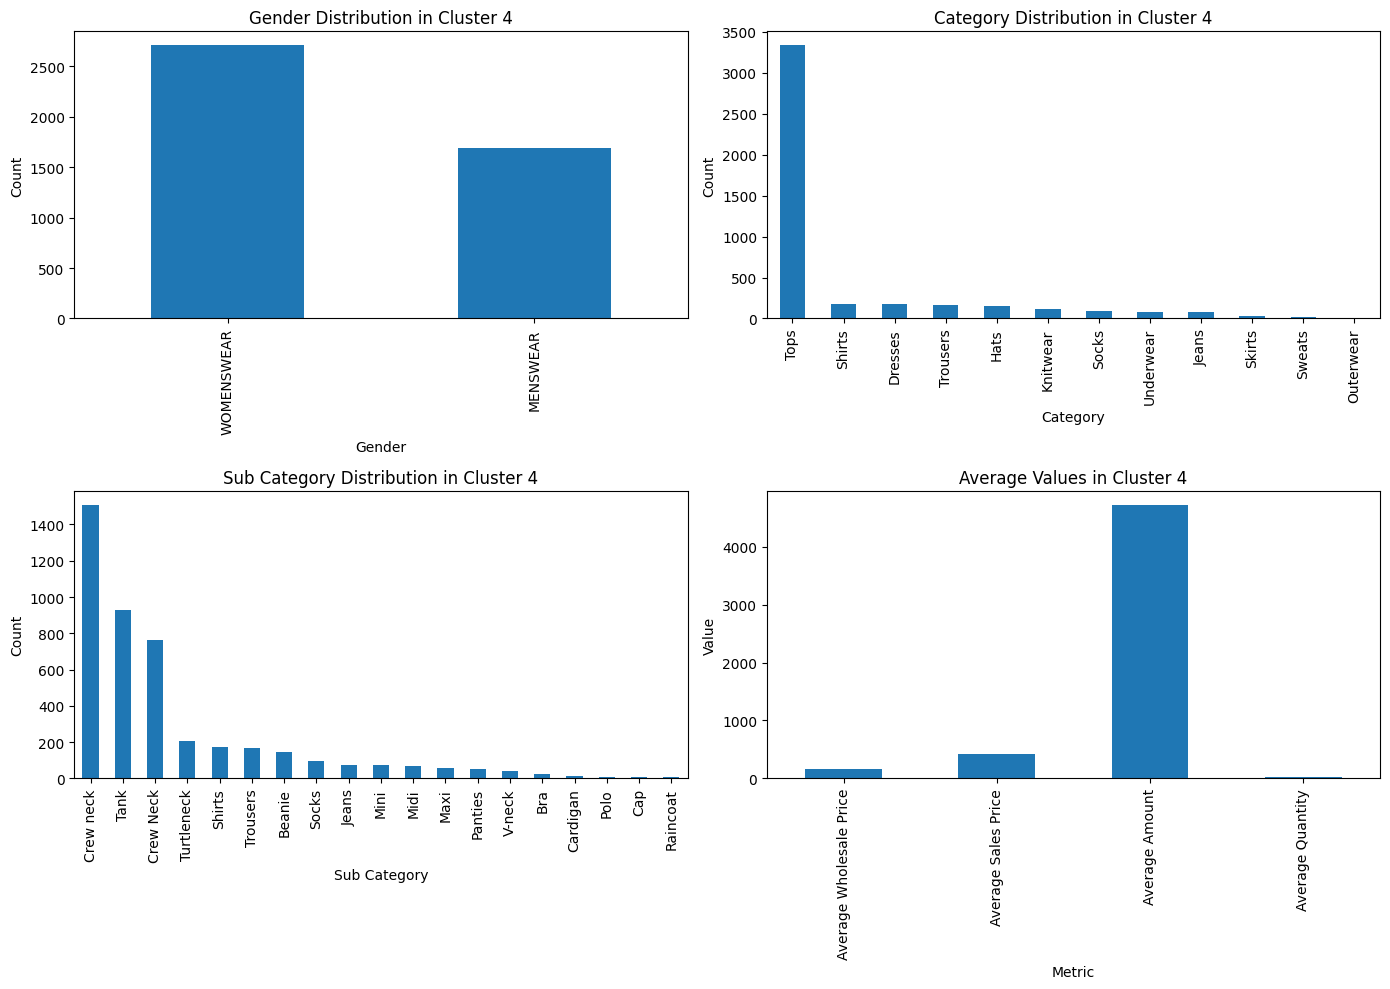

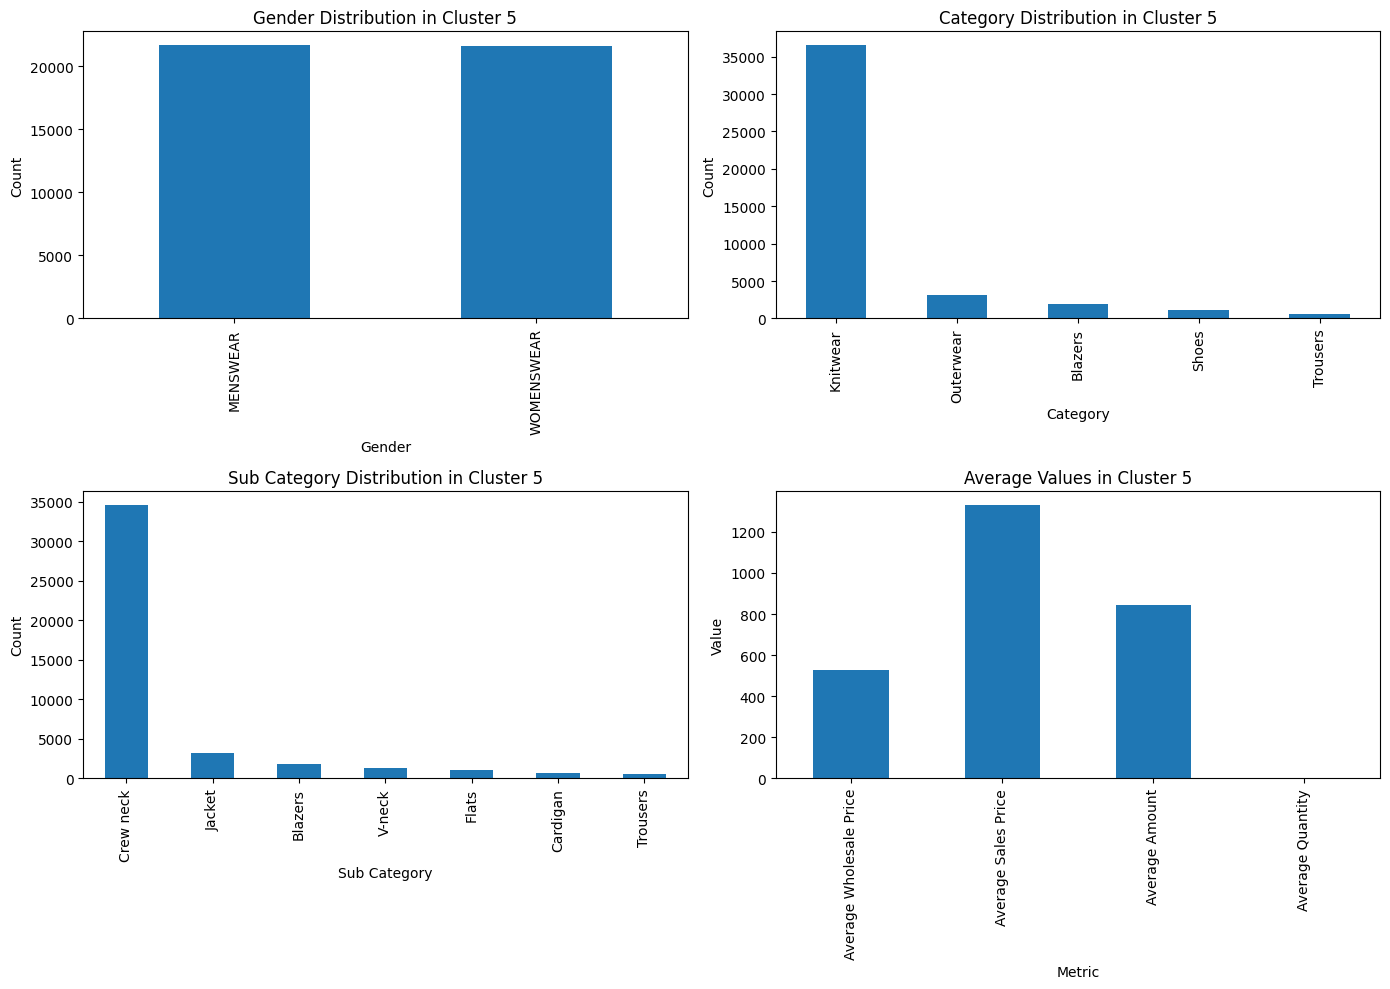

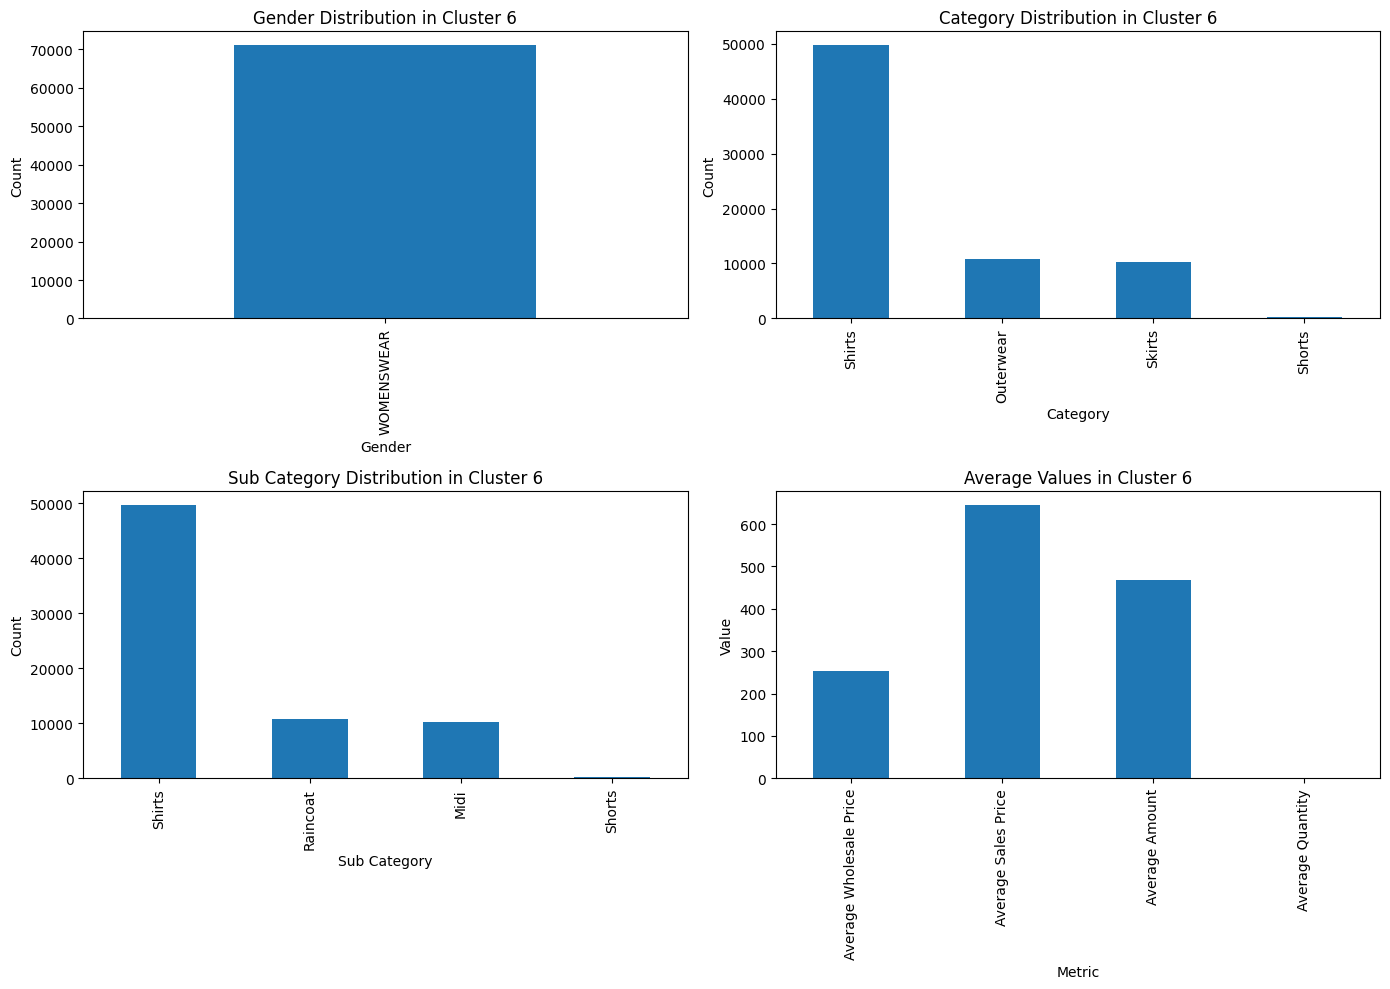

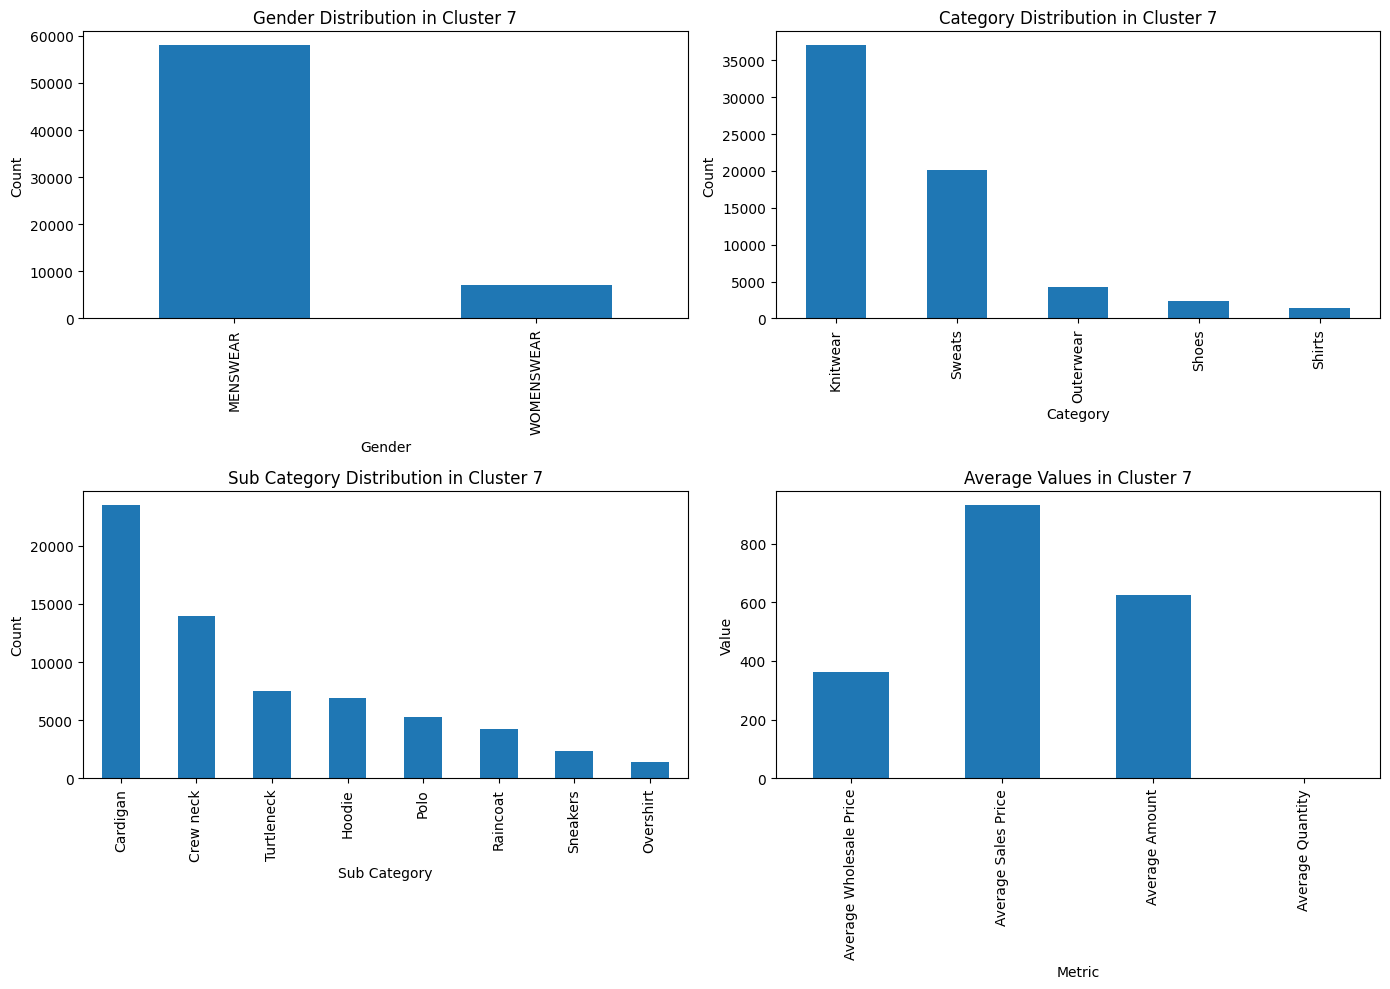

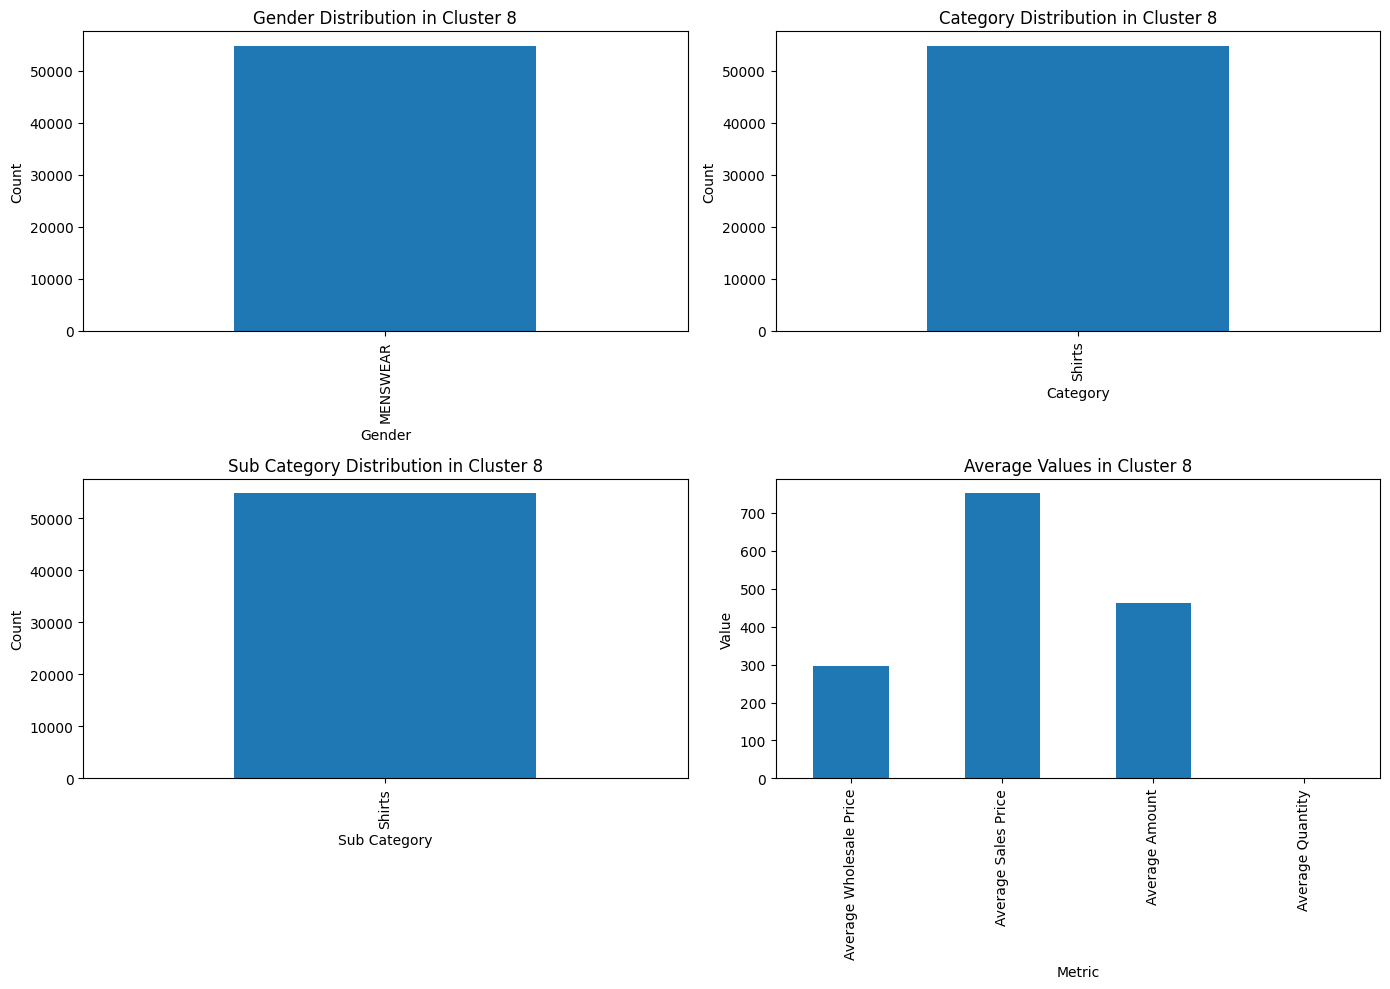

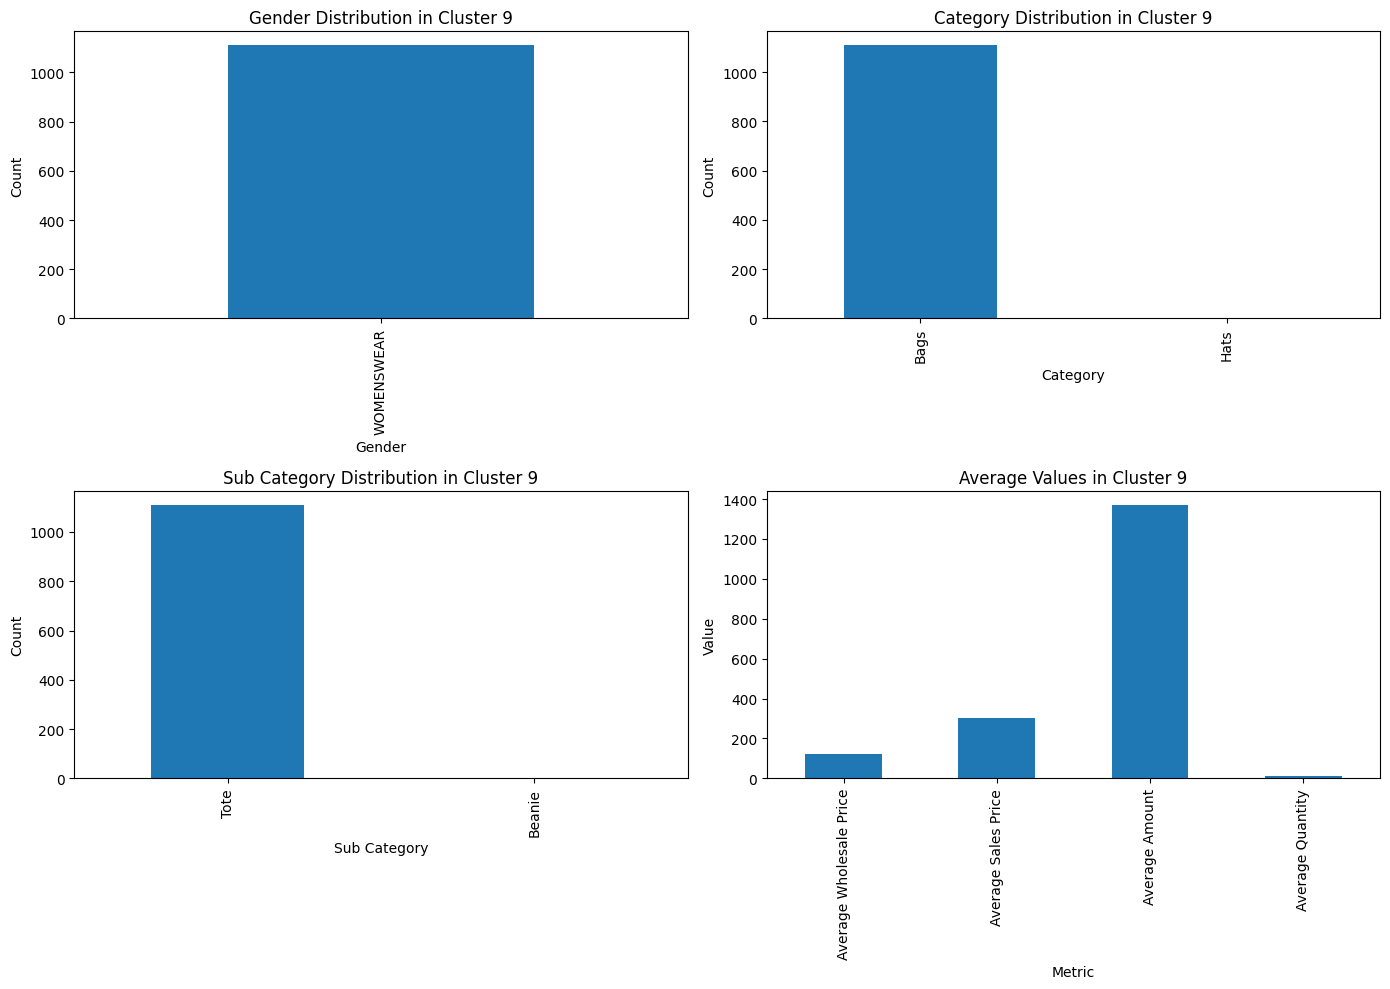

In [45]:
highest_values = []
for i in sorted(df["Cluster_" + cluster_type].unique()):
    if plot_clusters:
        average_values = plot_cluster_info(i, cluster_type=cluster_type)

### KMeans

In [42]:
plot_clusters = True
cluster_type = 'KMeans'

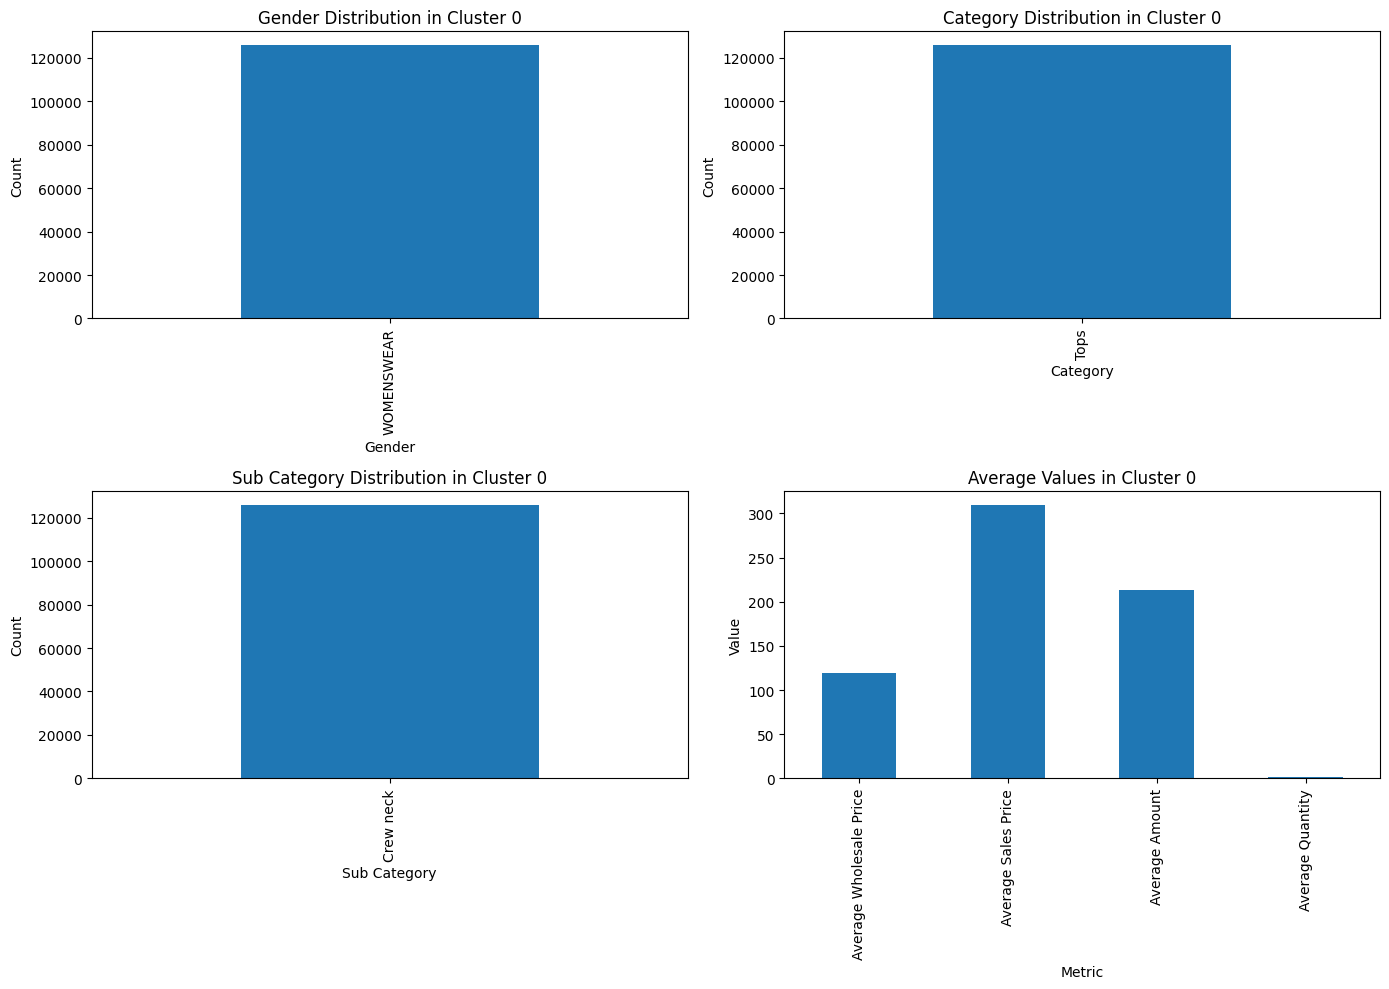

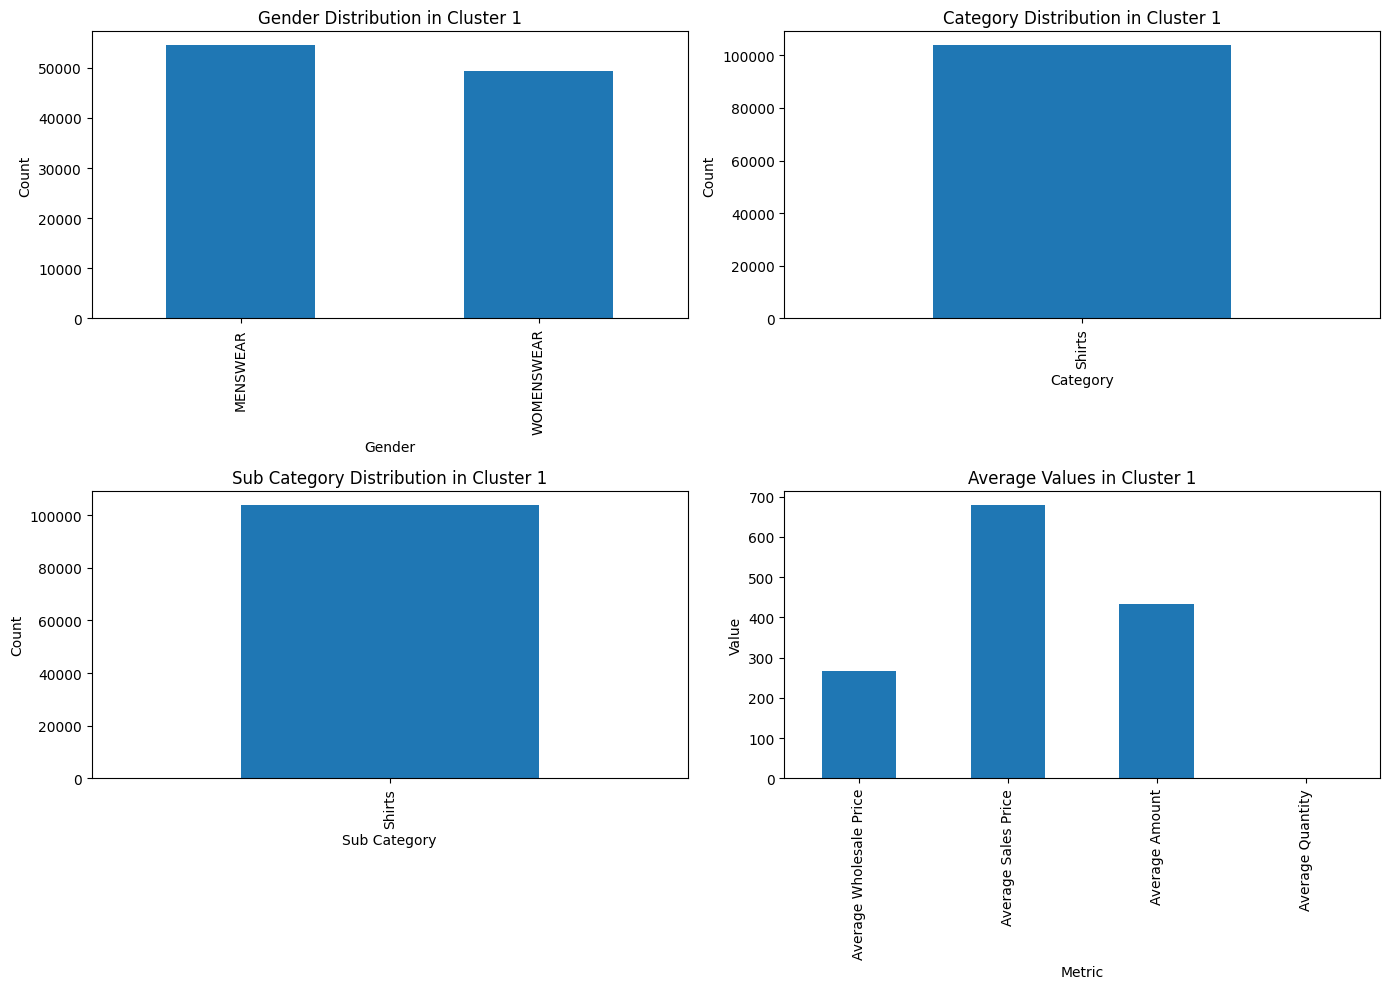

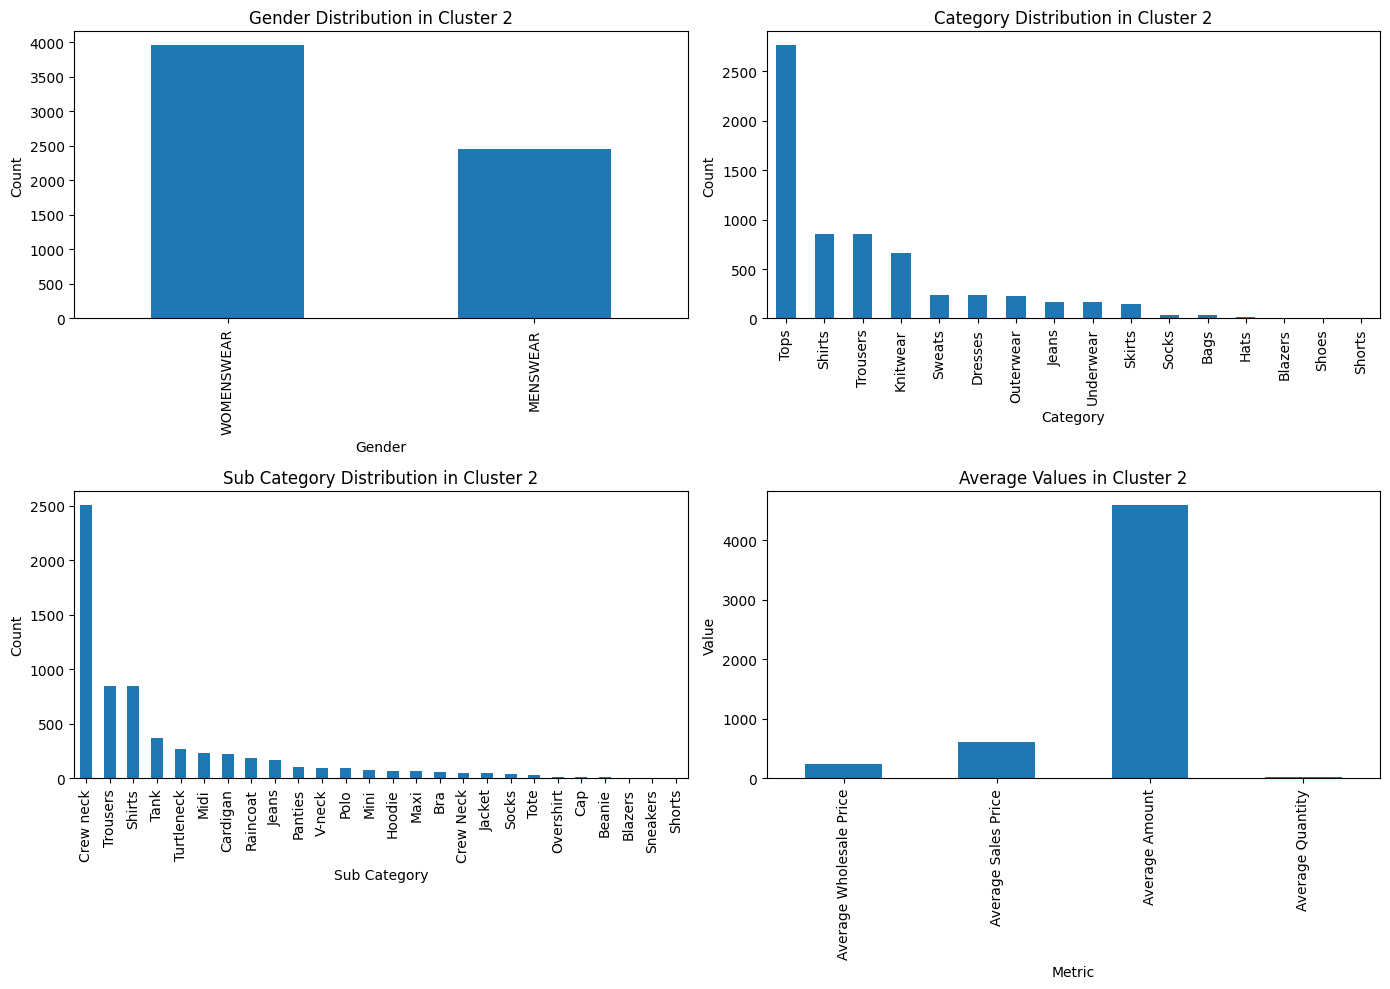

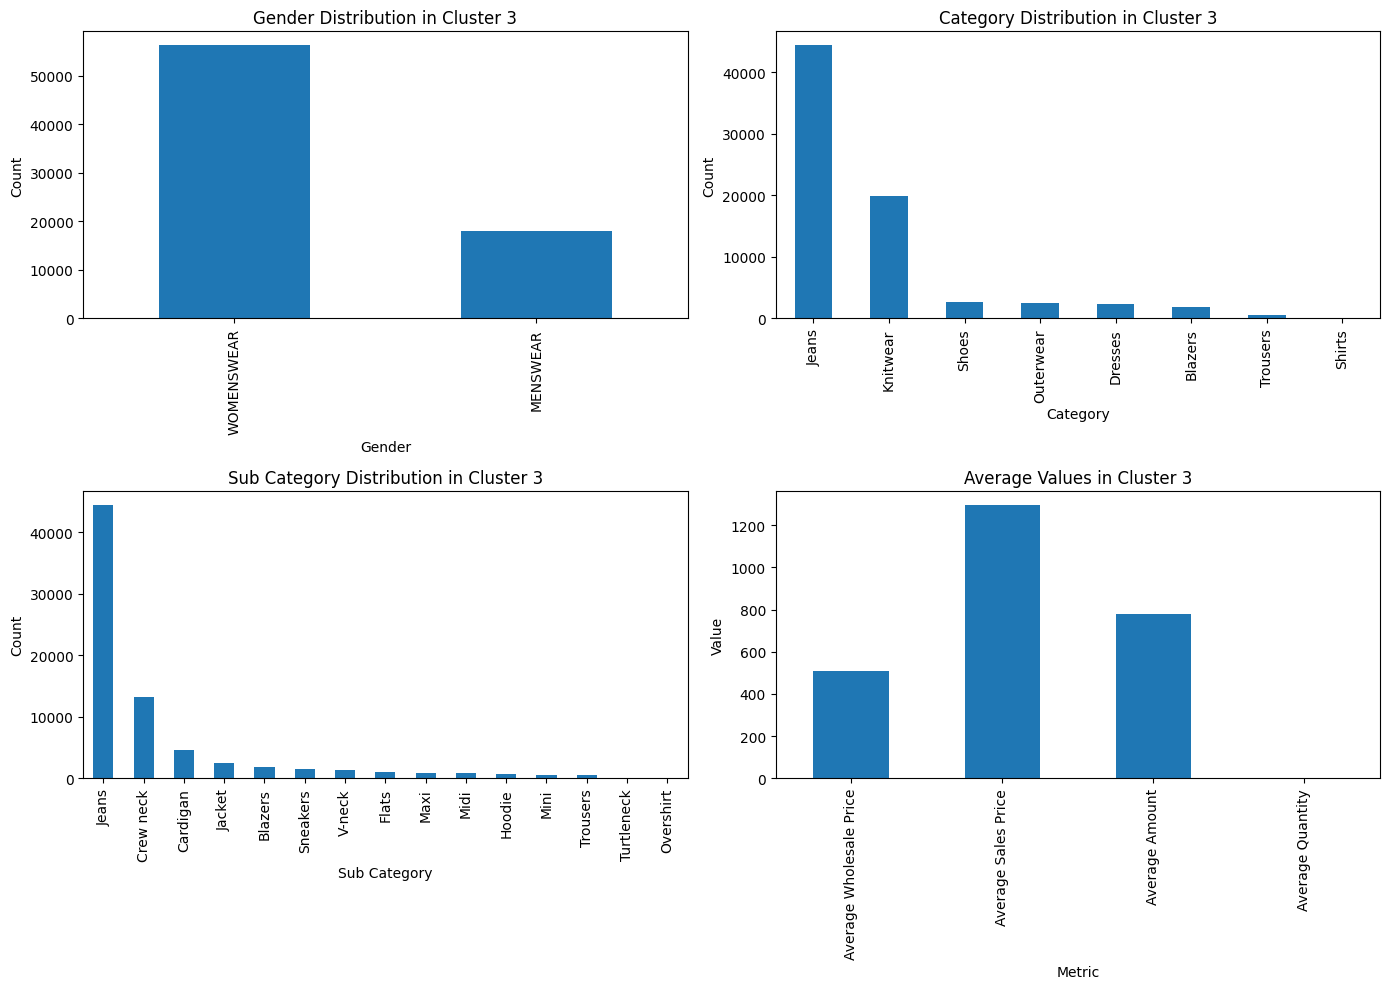

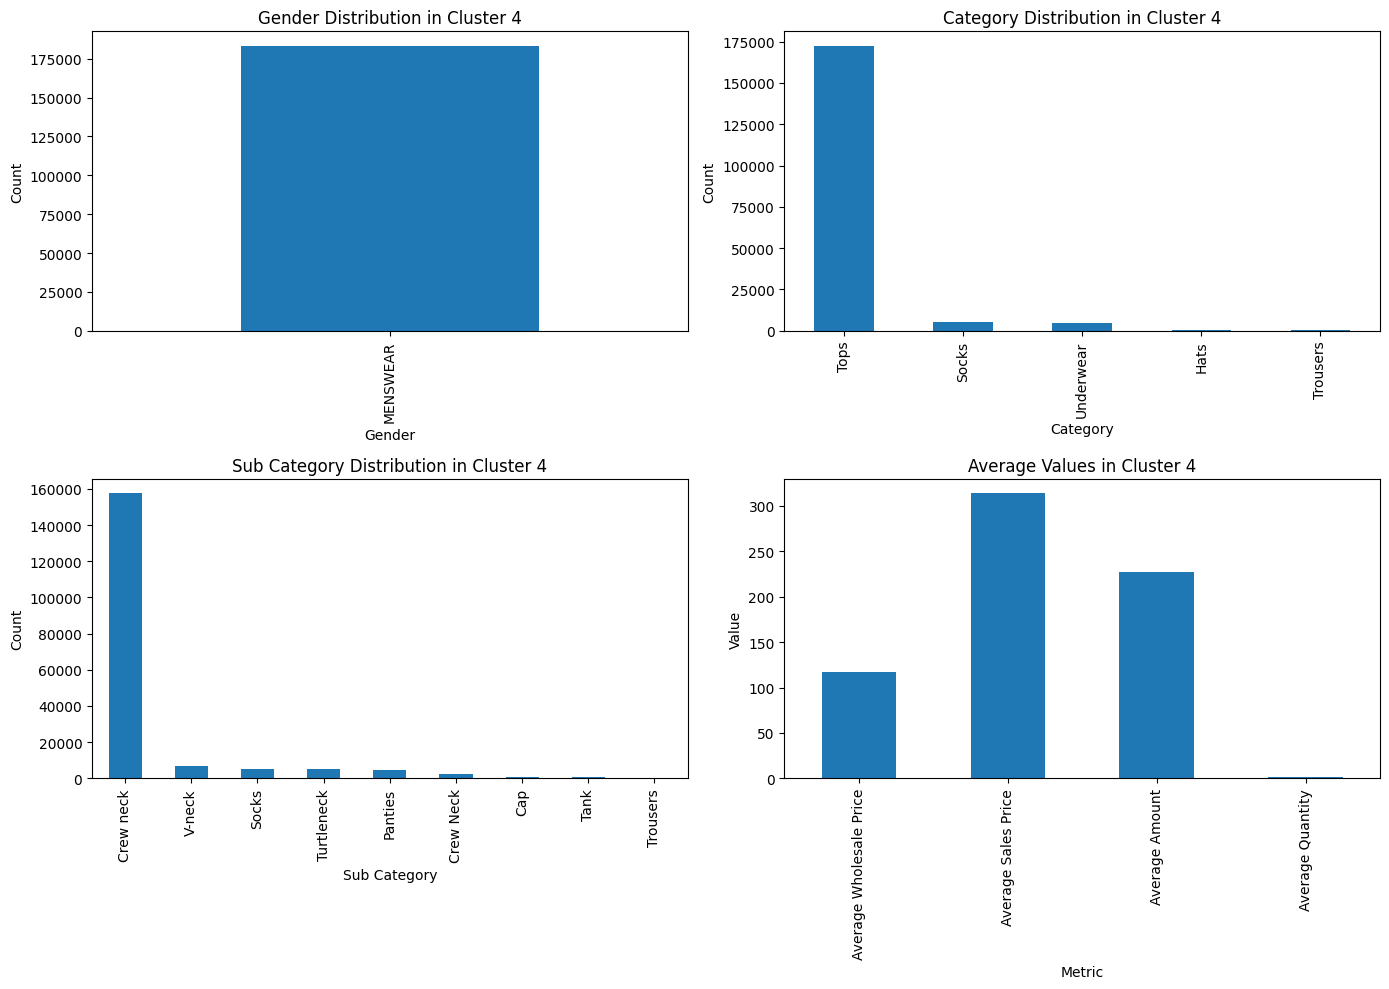

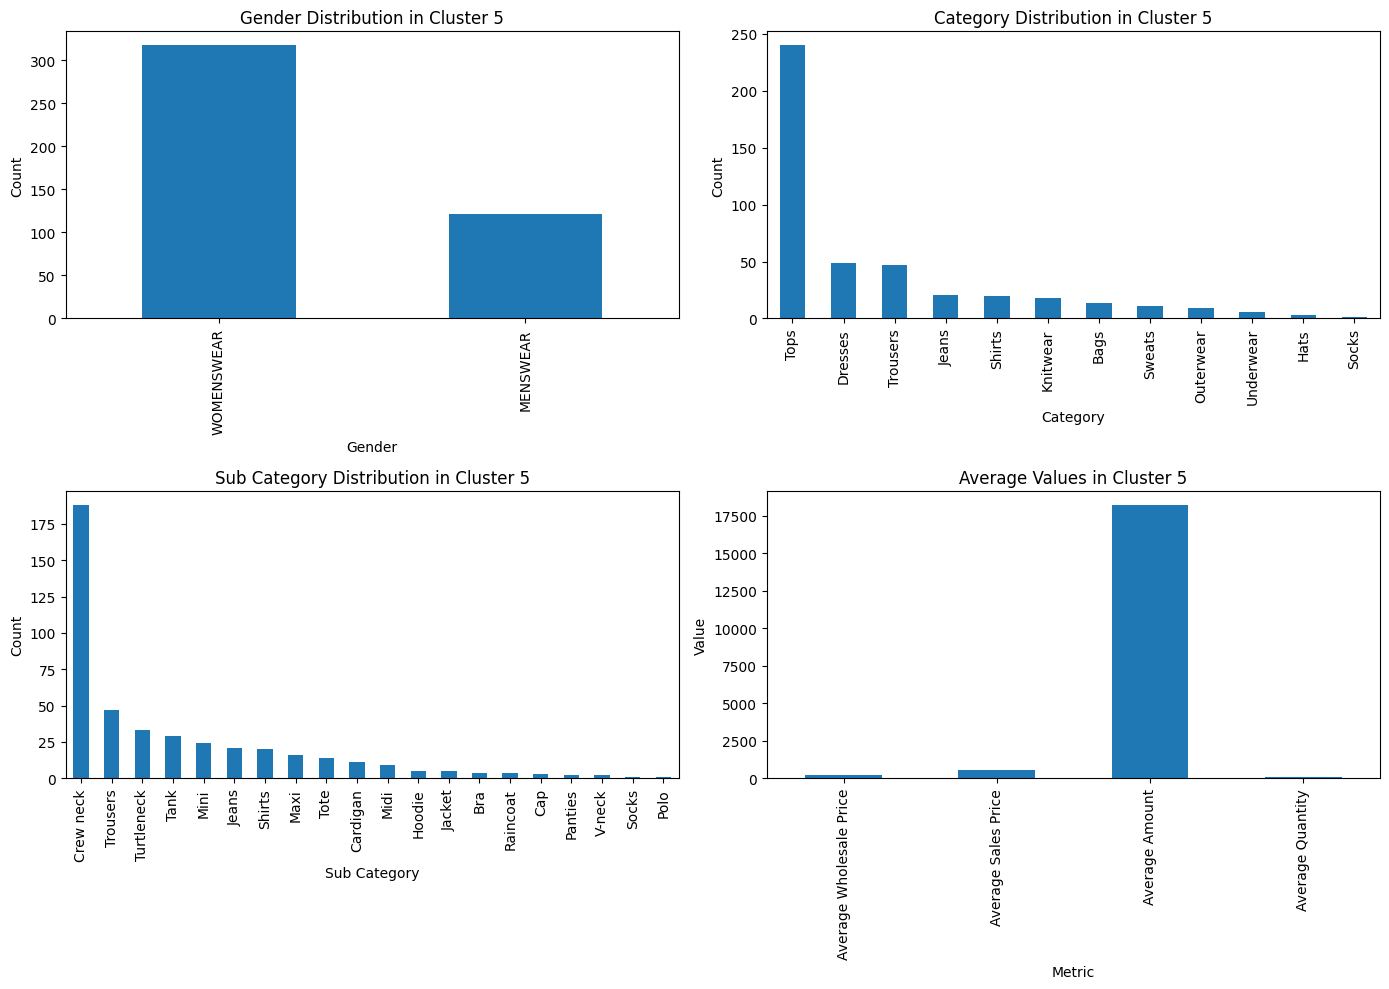

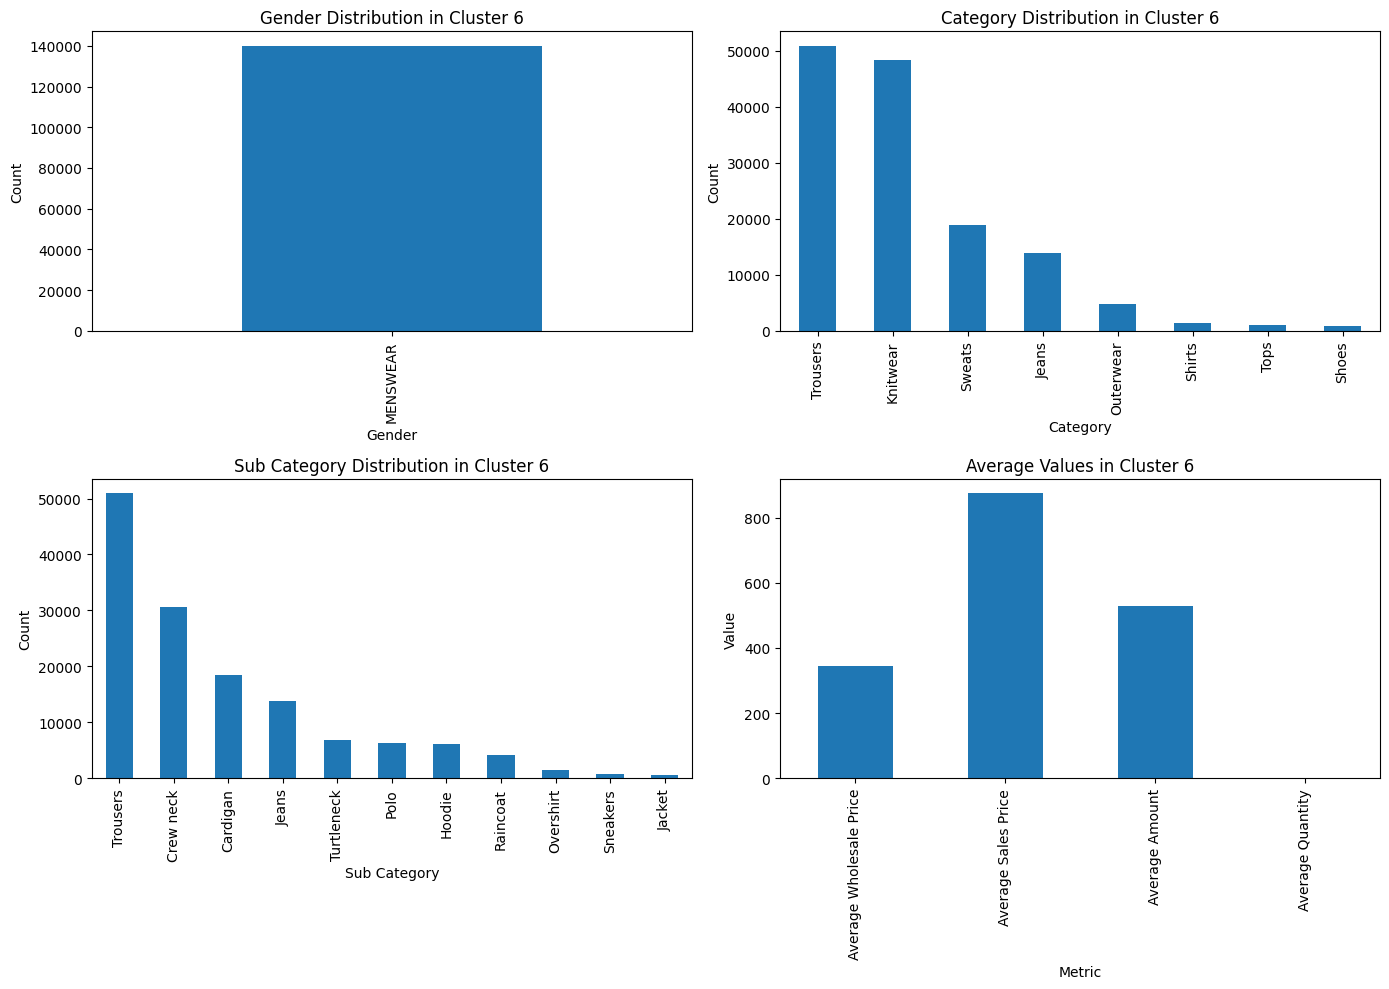

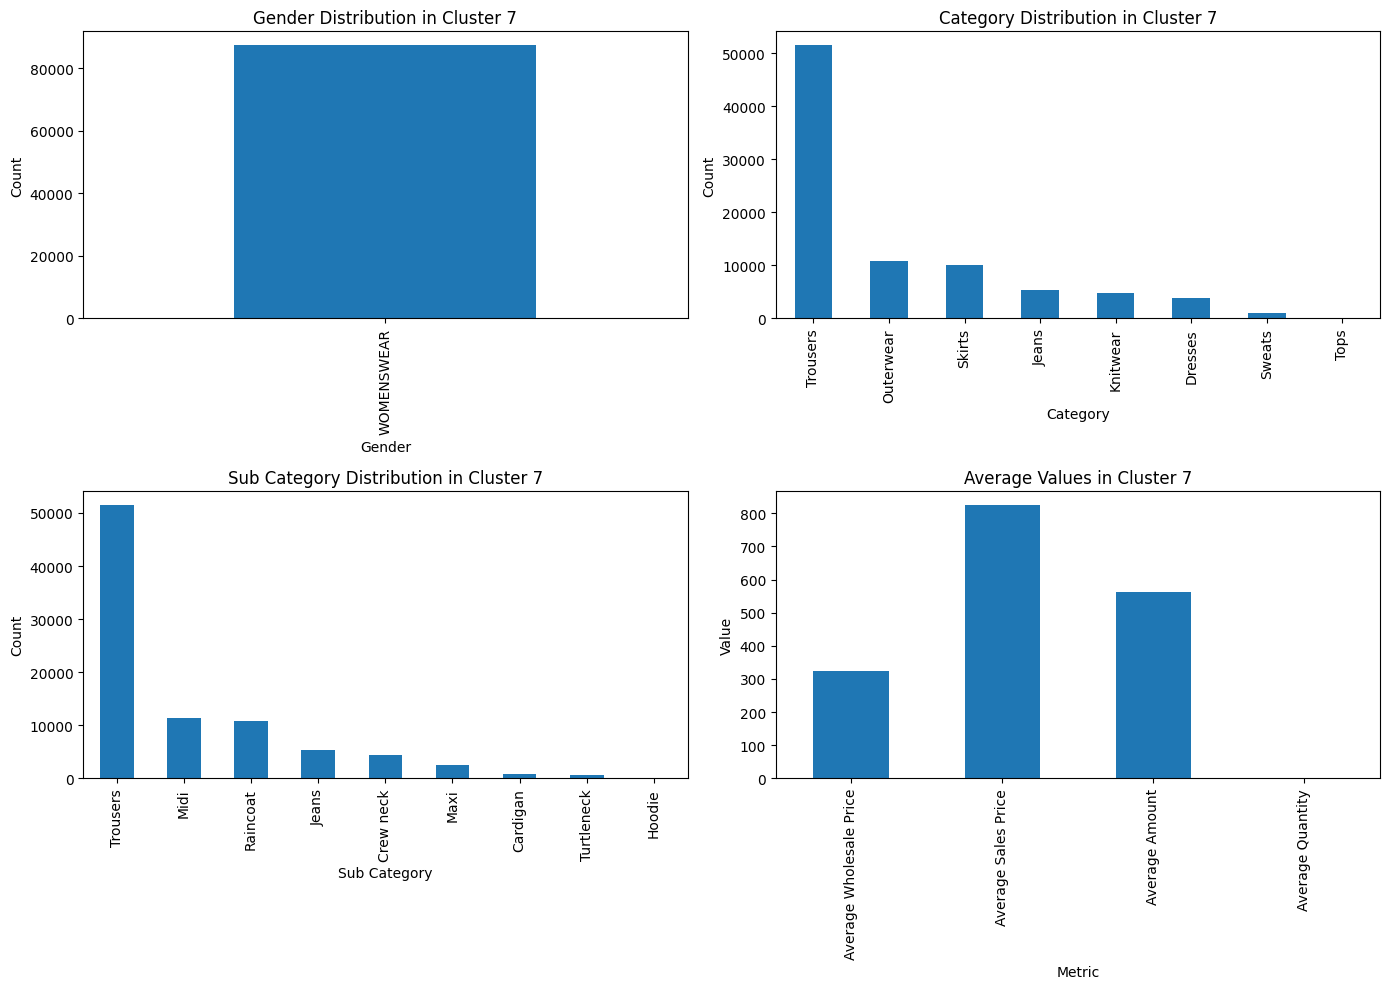

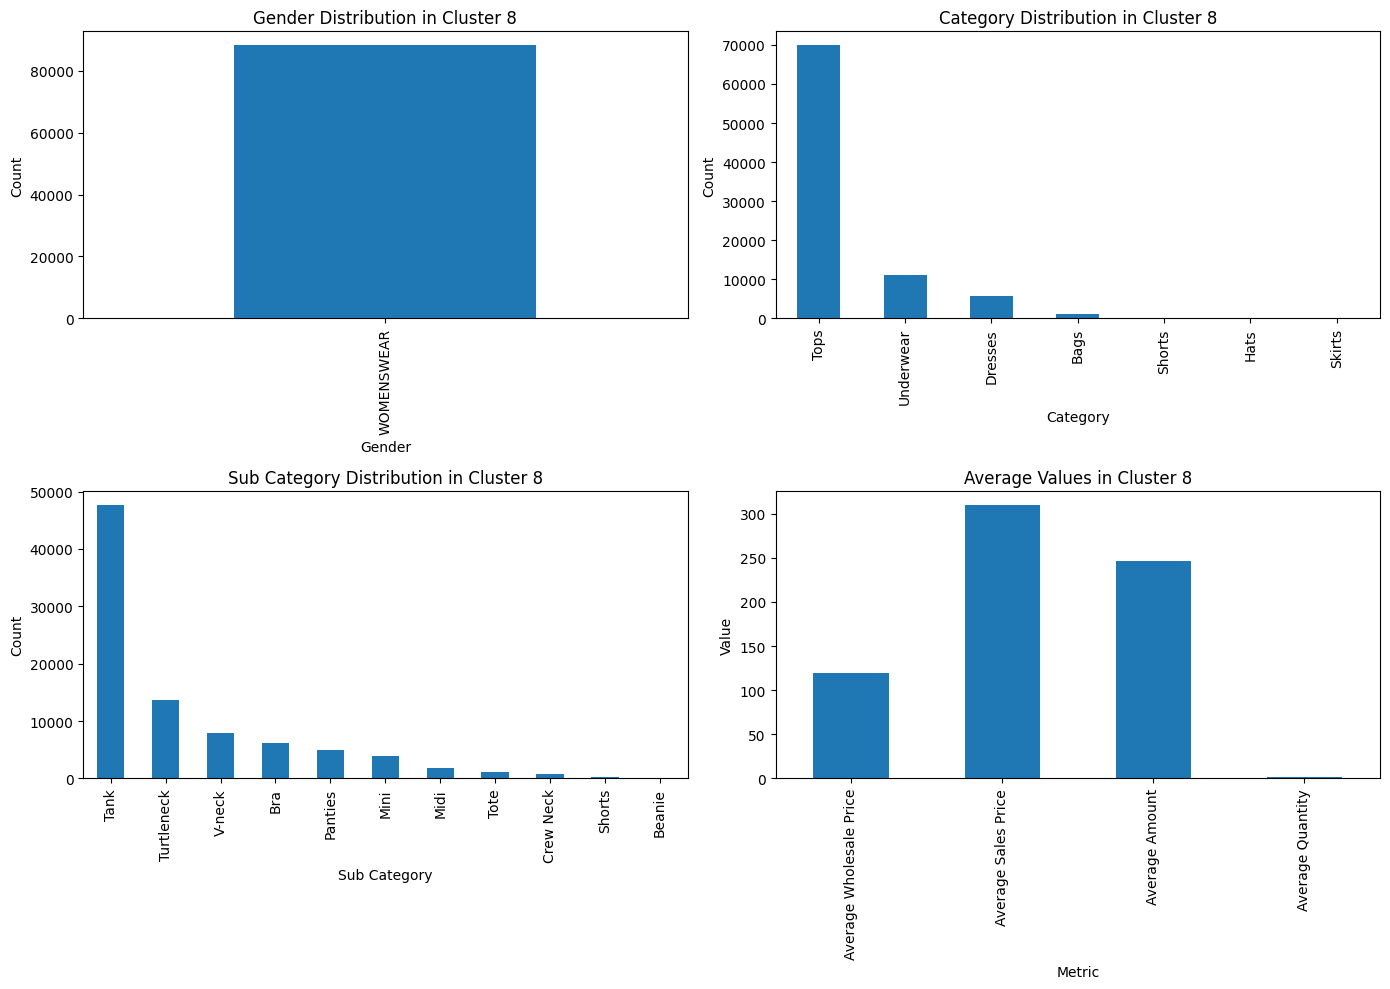

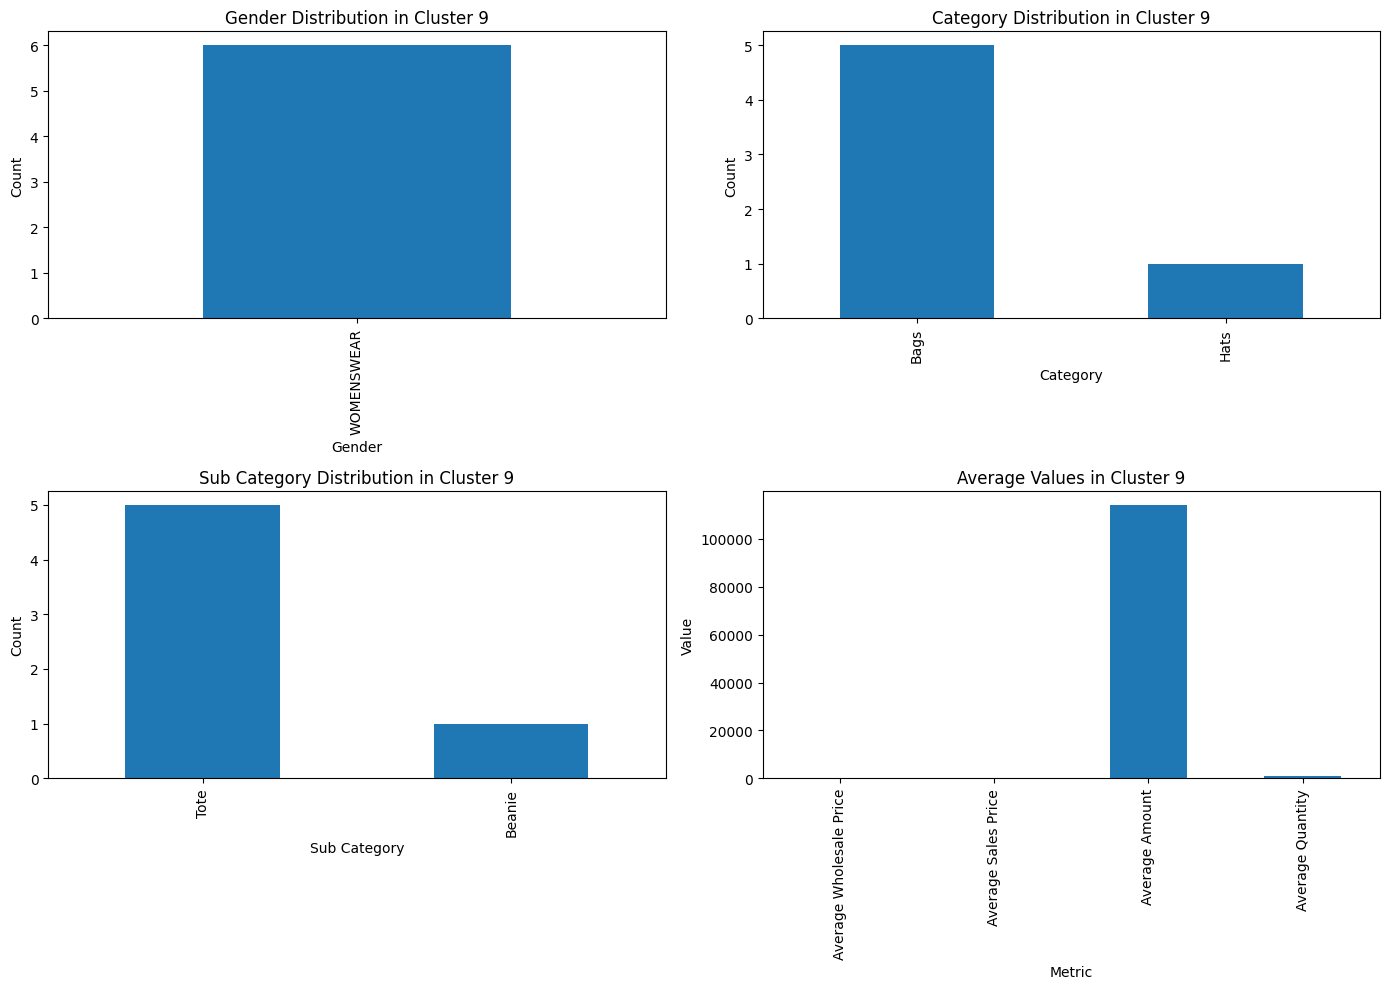

In [43]:
highest_values = []
for i in sorted(df["Cluster_" + cluster_type].unique()):
    if plot_clusters:
        average_values = plot_cluster_info(i, cluster_type=cluster_type)

## Save the clusters ##

In [ ]:
df.to_csv('data/sales_invoiced_lines_basics_cleaned_clustered.csv', index=False)

</details>